In [27]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This is an implementation of Andrej Karpathy's micrograd: https://youtu.be/VMj-3S1tku0?si=pJo8RS2T-aUz9hAh

# understand derivatives

In [28]:
a = 3
b = 4
c = a * b
c

12

In [29]:
# calculate derivative with regard to a
h = 0.0001
L = ((a + h) * b - a * b)/h
L

4.000000000008441

# `Value` class will track gradient

For backpropagation, we are interested in how each weights impacts the loss function (L), L wrt. a, b , c, d
To do that, we use the attribute `grad` to keep track of the gradient wrt. L. For each variable x, the grad is defined as $dL/dx$. To backpropagate effectively, use chain rules to cache the result of previous gradients. For example, if $c = f(b)$, then $dL/db = dL/dc \cdot dc/db$.

In [30]:
class Value:
    def __init__(self, data, _children=(), _op=''):
        self.data = data
        self.grad = 0
        # this function applies the chain rule; for leaf nodes, there is nothing to do
        self._backward = lambda: None
        # children is a tuple that records values that made up the current value
        self._prev = set(_children)
        # this records the previous operation that applied to the children, for graphviz
        self._op = _op

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        ret = Value(self.data + other.data, (self, other), '+')
        # take ret's grad and propagate to self and other
        def _backward():
            self.grad += 1.0 * ret.grad
            other.grad += 1.0 * ret.grad
        ret._backward = _backward
        return ret

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        ret = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * ret.grad
            other.grad += self.data * ret.grad
        ret._backward = _backward
        return ret
    
    def exp(self):
        data = self.data
        out = Value(math.exp(data), (self,), 'exp')
        def _backward():
            # print(f"exp with self.data {self.data} self.grad {self.grad} and out.data {out.data} out.grad {out.grad}")
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
        
    # composite function, calculate tanh in one go
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) *out.grad
        out._backward = _backward
        return out

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"        
        out = Value(self.data**other, (self,), f'**{other}')
        def _backward():
            # print(f"pow with self.data {self.data} to the {other} power, self.grad {self.grad} and out.data {out.data} out.grad {out.grad}")
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
        
    def __neg__(self): # -self
        return self * -1

    def __radd__(self, other): # other + self
        return self + other

    def __sub__(self, other): # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def __rmul__(self, other): # other * self
        return self * other

    def __truediv__(self, other): # self / other
        return self * other**-1

    def __rtruediv__(self, other): # other / self
        return other * self**-1
        
    def __repr__(self):
        return f"Value(data={self.data},grad={self.grad})"

In [31]:
a = Value(2)
b = 3 * a
c = 7
d = b + c - a
b.grad = 1
b._backward()
a.grad

3

# Visualization for graphing calculation history

In [32]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ data %.4f | grad %.4f}" % (n.data, n.grad), shape='record')
        if n._op:
            dot.node(name = uid + n._op, label = n._op)
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot
    

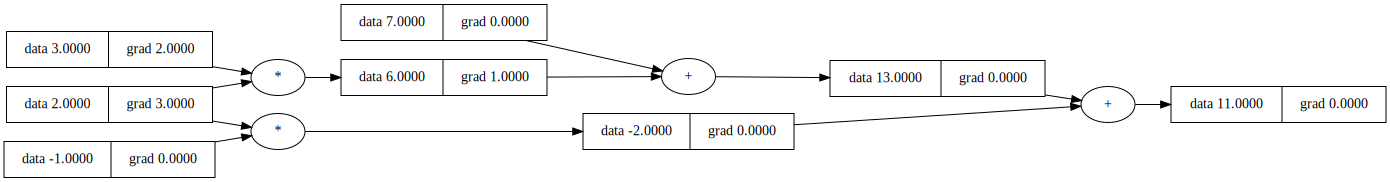

In [33]:
draw_dot(d)

# apply back propagation one step at a time

In [34]:
x1 = Value(2)
x2 = Value(0)
w1 = Value(-3)
w2 = Value(1)
b = Value(6.8813735)
x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
o = n.tanh()

o.grad = 1
o._backward()
b._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

# o.backward()


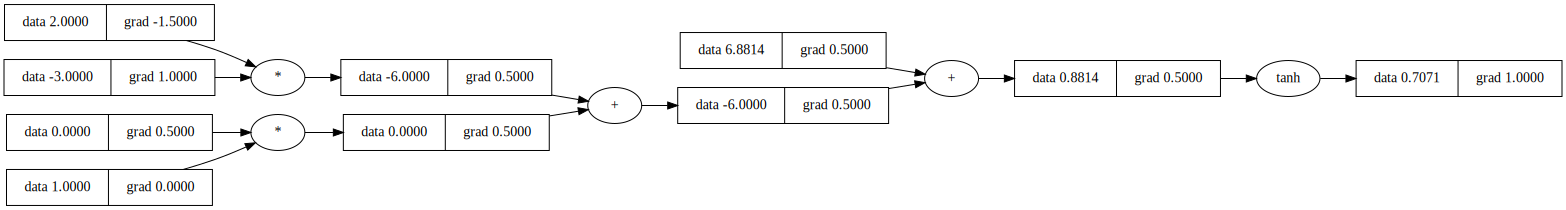

In [35]:
draw_dot(o)

# backward functions (with topological sort)

In [36]:
def backward(self):
    topo = []
    visited = set()
    # important! use topological sort to traverse the graph
    def build_topo(v):
        if v not in visited:
            visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
    build_topo(self)
    self.grad = 1
    for v in reversed(topo):
        # print(v)
        v._backward()

Value.backward = backward

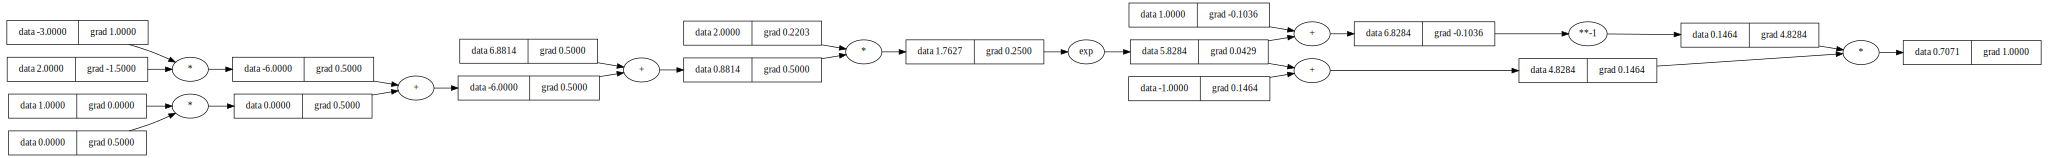

In [37]:
x1 = Value(2)
x2 = Value(0)
w1 = Value(-3)
w2 = Value(1)
b = Value(6.8813735)
x1w1 = x1*w1
x2w2 = x2*w2
x1w1x2w2 = x1w1 + x2w2
n = x1w1x2w2 + b
e = (2*n).exp()
o = (e-1)/(e+1)

o.backward()
draw_dot(o)

# use PyTorch for the same example (skip)

# construct Neural Network

* an artificial **neuron** can be represented as $$f(\sum_i w_ix_i + b)$$
* a **layer** is a set of neurons
* a **multi-layer perceptron (MLP)** consists of several layers

In [38]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        activation = sum((wi * xi for wi, xi in  zip(self.w, x)), self.b)
        out = activation.tanh()
        return out
        
    def parameters(self):
        return self.w + [self.b]
        
class Layer: 
    # layer consists of nout number of neurons that each have nin dimension
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out

    def parameters(self):
        return [p for n in self.neurons for p in n.parameters()]

class MLP:
    # MLP has nin number of input and an array (nouts) of layers
    def __init__(self, nin, nouts):
        # sz is the array of all layers, including the initial input
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

x = [2.0, 3.0, -1] #input
n = Neuron(3)
print(n(x))
l = Layer(2, 3)
print(l(x))
m = MLP(3, [4, 4, 1])
m(x)

Value(data=-0.34629086278899307,grad=0)
[Value(data=0.9254713653736204,grad=0), Value(data=0.4438732055985735,grad=0), Value(data=-0.9989747436887132,grad=0)]


Value(data=-0.6050647858295485,grad=0)

In [39]:
# draw_dot(m(x))

# MLP backpropagation in practice

In [40]:
xs = [
    [1, 4, -2],
    [-1, 3, 2],
    [1, 0.7, 3],
    [-1, .2, 1]
] #input dataset
ys = [1, -1, 1, -1] #desired results

## gradient descent dissection

In [41]:
ypred = [m(x) for x in xs]
# mean square error loss function, forward pass
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=3.801274248481689,grad=0)

In [42]:
# backpropagate, backward pass
loss.backward()

In [43]:
# this gradient (assume negative) means a small inrease in weight of this particular neuron will decrease the loss
m.layers[0].neurons[0].w[0].grad

0.7688174488034804

In [44]:
#gradient descent to minimize loss, nudge
for p in m.parameters():
    # important gradient points to the direction of increasing loss, so we need a negative sign here
    p.data += -0.01 * p.grad

## put them together

In [45]:
for k in range(10):
    #forward pass
    ypred = [m(x) for x in xs]
    loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
    
    #backward pass
    for p in m.parameters():
        #zero grad to reset
        p.grad = 0.0
    loss.backward()
    
    #update
    for p in m.parameters():
        p.data += -0.01 * p.grad
    # observe the decreasing loss
    print(k, loss.data)

0 3.2258988230828405
1 2.7680350626672316
2 2.413667851466662
3 2.1404152428335776
4 1.9280457488069391
5 1.7594147304413719
6 1.621425163725128
7 1.505058116034132
8 1.404411309720452
9 1.3156234552554216
